In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/andrewmvd/leukemia-classification")

Skipping, found downloaded files in ".\leukemia-classification" (use force=True to force download)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Load and preprocess data
train_generator = train_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/training_data/fold/fold_0',
    target_size=(150, 150),
    batch_size=512,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/validation_data',
    target_size=(150, 150),
    batch_size=512,
    class_mode='categorical'
)


Found 4690 images belonging to 2 classes.
Found 1867 images belonging to 1 classes.


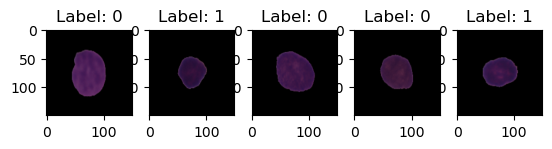

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust the number of images you want to display
num_images = 5

# Set the generator to retrieve images
images, labels = next(train_generator)  # Get the next batch of images and labels

# Display the images and their labels
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {np.argmax(labels[i])}')  # Assuming one-hot encoded labels

plt.show()


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))


In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
train_samples = len(train_generator.filenames)

In [7]:
validation_samples = len(validation_generator.filenames)

In [41]:
model.fit(
    train_generator,
    steps_per_epoch=train_samples // 512,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_samples // 512
)

Epoch 1/10
9/9 [==============================] - 125s 13s/step - loss: 0.6362 - accuracy: 0.6515 - val_loss: 1.8973 - val_accuracy: 0.8242
Epoch 2/10
9/9 [==============================] - 120s 12s/step - loss: 0.5491 - accuracy: 0.7386 - val_loss: 2.0116 - val_accuracy: 0.8789
Epoch 3/10
9/9 [==============================] - 118s 12s/step - loss: 0.5482 - accuracy: 0.7317 - val_loss: 1.9343 - val_accuracy: 0.8698
Epoch 4/10
9/9 [==============================] - 109s 13s/step - loss: 0.5401 - accuracy: 0.7367 - val_loss: 1.8829 - val_accuracy: 0.8464
Epoch 5/10
9/9 [==============================] - 115s 14s/step - loss: 0.5441 - accuracy: 0.7429 - val_loss: 1.8907 - val_accuracy: 0.8548
Epoch 6/10
9/9 [==============================] - 115s 12s/step - loss: 0.5300 - accuracy: 0.7451 - val_loss: 1.8478 - val_accuracy: 0.8652
Epoch 7/10
9/9 [==============================] - 106s 11s/step - loss: 0.5370 - accuracy: 0.7396 - val_loss: 1.9168 - val_accuracy: 0.8997
Epoch 8/10
9/9 [====

In [42]:
test_generator = test_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/testing_data/fold_2',
    target_size=(150, 150),
    batch_size=512,
    class_mode='categorical'
)
test_loss, test_accuracy = model.evaluate(test_generator)

Found 3553 images belonging to 2 classes.
7/7 [==============================] - 20s 3s/step - loss: 0.5498 - accuracy: 0.7715


In [43]:
predictions = model.predict(test_generator)
# Get the true labels from the test data generator
true_labels = test_generator.classes

# Calculate the accuracy
from sklearn.metrics import accuracy_score

predicted_labels = np.argmax(predictions, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")

7/7 [==============================] - 18s 2s/step
Accuracy: 63.97%


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Set image dimensions
img_width = 224
img_height = 224

# Set batch size
batch_size = 32

# Set the number of classes (e.g., binary classification)
num_classes = 2  # Change this based on your dataset

# Define the base model (MobileNetV2) with pre-trained weights
base_model = MobileNetV2(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Add a custom classification head
x = base_model.output
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the paths to your training and validation data
train_data_dir = 'leukemia-classification/C-NMC_Leukemia/training_data/fold/fold_0'
validation_data_dir = 'leukemia-classification/C-NMC_Leukemia/validation_data'

# Calculate the number of train and validation samples
train_samples = len(train_datagen.flow_from_directory(train_data_dir).filenames)
validation_samples = len(test_datagen.flow_from_directory(validation_data_dir).filenames)

# Set the number of training epochs
epochs = 10  # Adjust as needed

# Create data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

Found 4690 images belonging to 2 classes.
Found 1867 images belonging to 1 classes.
Found 4690 images belonging to 2 classes.
Found 1867 images belonging to 1 classes.
Epoch 1/10
146/146 [==============================] - 261s 2s/step - loss: 0.5195 - accuracy: 0.7523 - val_loss: 2.0456 - val_accuracy: 0.9165
Epoch 2/10
146/146 [==============================] - 247s 2s/step - loss: 0.4642 - accuracy: 0.7802 - val_loss: 1.9391 - val_accuracy: 0.8497
Epoch 3/10
146/146 [==============================] - 243s 2s/step - loss: 0.4436 - accuracy: 0.7941 - val_loss: 2.0052 - val_accuracy: 0.8944
Epoch 4/10
146/146 [==============================] - 245s 2s/step - loss: 0.4382 - accuracy: 0.7995 - val_loss: 2.0654 - val_accuracy: 0.8825
Epoch 5/10
146/146 [==============================] - 249s 2s/step - loss: 0.4264 - accuracy: 0.8012 - val_loss: 2.5436 - val_accuracy: 0.9774
Epoch 6/10
146/146 [==============================] - 246s 2s/step - loss: 0.4196 - accuracy: 0.8044 - val_loss: 2.39

In [7]:
test_generator = test_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/testing_data/fold_2',
    target_size=(150, 150),
    batch_size=512,
    class_mode='categorical'
)
test_loss, test_accuracy = model.evaluate(test_generator)

Found 3553 images belonging to 2 classes.
7/7 [==============================] - 47s 6s/step - loss: 1.3346 - accuracy: 0.6434


In [8]:
predictions = model.predict(test_generator)
# Get the true labels from the test data generator
true_labels = test_generator.classes

# Calculate the accuracy
from sklearn.metrics import accuracy_score

predicted_labels = np.argmax(predictions, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")

7/7 [==============================] - 51s 7s/step
Accuracy: 51.11%


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Set image dimensions
img_width = 224
img_height = 224

# Set batch size
batch_size = 32

# Set the number of classes (e.g., binary classification)
num_classes = 2  # Change this based on your dataset

# Define the base model (VGG16) with pre-trained weights
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom classification head
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the paths to your training and validation data
train_data_dir = 'leukemia-classification/C-NMC_Leukemia/training_data/fold/fold_0'
validation_data_dir = 'leukemia-classification/C-NMC_Leukemia/validation_data'

# Calculate the number of train and validation samples
train_samples = len(train_datagen.flow_from_directory(train_data_dir).filenames)
validation_samples = len(test_datagen.flow_from_directory(validation_data_dir).filenames)

# Set the number of training epochs
epochs = 5  # Adjust as needed

# Create data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

Found 4690 images belonging to 2 classes.
Found 1867 images belonging to 1 classes.
Found 4690 images belonging to 2 classes.
Found 1867 images belonging to 1 classes.
Epoch 1/5
146/146 [==============================] - 1100s 8s/step - loss: 0.8892 - accuracy: 0.6853 - val_loss: 1.5941 - val_accuracy: 0.7538
Epoch 2/5
146/146 [==============================] - 1065s 7s/step - loss: 0.5511 - accuracy: 0.7325 - val_loss: 1.6896 - val_accuracy: 0.9256
Epoch 3/5
146/146 [==============================] - 1081s 7s/step - loss: 0.5552 - accuracy: 0.7222 - val_loss: 1.6276 - val_accuracy: 0.8351
Epoch 4/5
146/146 [==============================] - 982s 7s/step - loss: 0.5455 - accuracy: 0.7353 - val_loss: 1.8951 - val_accuracy: 0.9154
Epoch 5/5
146/146 [==============================] - 910s 6s/step - loss: 0.5472 - accuracy: 0.7381 - val_loss: 1.5083 - val_accuracy: 0.9197


In [11]:
test_generator = test_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/testing_data/fold_2',
    target_size=(150, 150),
    batch_size=512,
    class_mode='categorical'
)
test_loss, test_accuracy = model.evaluate(test_generator)

Found 3553 images belonging to 2 classes.
7/7 [==============================] - 25s 3s/step - loss: 0.5819 - accuracy: 0.7667


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Set image dimensions
img_width = 224
img_height = 224

# Set batch size
batch_size = 512

# Set the number of classes (e.g., binary classification)
num_classes = 2  # Change this based on your dataset

# Define the base model (ResNet50) with pre-trained weights
base_model = ResNet50(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Add a custom classification head
x = base_model.output
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define a learning rate schedule
def learning_rate_schedule(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    else:
        return 0.0001

# Compile the model with the learning rate schedule
model.compile(optimizer=Adam(learning_rate=learning_rate_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the paths to your training and validation data
train_data_dir = 'leukemia-classification/C-NMC_Leukemia/training_data/fold/fold_0'
validation_data_dir = 'leukemia-classification/C-NMC_Leukemia/validation_data'

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create a validation generator
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4690 images belonging to 2 classes.
Found 1867 images belonging to 1 classes.


In [8]:
# Set the number of training epochs
epochs = 10

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[LearningRateScheduler(learning_rate_schedule), early_stopping]
)


Epoch 1/10
9/9 [==============================] - 153s 16s/step - loss: 0.6427 - accuracy: 0.6491 - val_loss: 1.9734 - val_accuracy: 0.7240
Epoch 2/10
9/9 [==============================] - 145s 15s/step - loss: 0.5574 - accuracy: 0.7344 - val_loss: 1.8118 - val_accuracy: 0.8138
Epoch 3/10
9/9 [==============================] - 137s 15s/step - loss: 0.5448 - accuracy: 0.7408 - val_loss: 1.7980 - val_accuracy: 0.8294
Epoch 4/10
9/9 [==============================] - 138s 14s/step - loss: 0.5356 - accuracy: 0.7413 - val_loss: 1.6764 - val_accuracy: 0.8229
Epoch 5/10
9/9 [==============================] - 133s 14s/step - loss: 0.5300 - accuracy: 0.7441 - val_loss: 1.7606 - val_accuracy: 0.8060
Epoch 6/10
9/9 [==============================] - 133s 16s/step - loss: 0.5399 - accuracy: 0.7384 - val_loss: 1.6600 - val_accuracy: 0.7956
Epoch 7/10
9/9 [==============================] - 134s 16s/step - loss: 0.5314 - accuracy: 0.7468 - val_loss: 1.5905 - val_accuracy: 0.8086
Epoch 8/10
9/9 [====

In [9]:
test_generator = test_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/testing_data/fold_2',
    target_size=(150, 150),
    batch_size=512,
    class_mode='categorical'
)
test_loss, test_accuracy = model.evaluate(test_generator)

Found 3553 images belonging to 2 classes.
7/7 [==============================] - 35s 5s/step - loss: 0.5819 - accuracy: 0.7667


In [10]:
predictions = model.predict(test_generator)
# Get the true labels from the test data generator
true_labels = test_generator.classes

# Calculate the accuracy
from sklearn.metrics import accuracy_score

predicted_labels = np.argmax(predictions, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")

7/7 [==============================] - 27s 4s/step
Accuracy: 65.41%


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape matching the InceptionV3 model
input_shape = (224, 224, 3)  # InceptionV3 requires 224X224 images

# Load the pre-trained InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: "leukemia" and "non-leukemia"

# Create the custom model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing and loading
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/training_data/fold/fold_0',  # Path to your training data directory
    target_size=input_shape[:2],
    batch_size=32,  # Adjust as needed
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/validation_data',  # Path to your validation data directory
    target_size=input_shape[:2],
    batch_size=64,  # Adjust as needed
    class_mode='categorical'
)


Found 4690 images belonging to 2 classes.
Found 1867 images belonging to 1 classes.


In [2]:

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/10
111/111 [==============================] - 186s 2s/step - loss: 0.5438 - accuracy: 0.7474 - val_loss: 2.5169 - val_accuracy: 0.9759
Epoch 2/10
111/111 [==============================] - 191s 2s/step - loss: 0.4908 - accuracy: 0.7743 - val_loss: 1.6104 - val_accuracy: 0.6947
Epoch 3/10
111/111 [==============================] - 192s 2s/step - loss: 0.4536 - accuracy: 0.7987 - val_loss: 2.1437 - val_accuracy: 0.9314
Epoch 4/10
111/111 [==============================] - 192s 2s/step - loss: 0.4408 - accuracy: 0.8100 - val_loss: 2.6060 - val_accuracy: 0.9893
Epoch 5/10
111/111 [==============================] - 191s 2s/step - loss: 0.4427 - accuracy: 0.8055 - val_loss: 2.0112 - val_accuracy: 0.8881
Epoch 6/10
111/111 [==============================] - 192s 2s/step - loss: 0.4368 - accuracy: 0.8098 - val_loss: 2.2029 - val_accuracy: 0.9823
Epoch 7/10
111/111 [==============================] - 191s 2s/step - loss: 0.4323 - accuracy: 0.8095 - val_loss: 2.3428 - val_accuracy: 0.9389

In [4]:

# Create a validation generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'leukemia-classification/C-NMC_Leukemia/testing_data/fold_2',
    target_size=(150, 150),
    batch_size=512,
    class_mode='categorical'
)
test_loss, test_accuracy = model.evaluate(test_generator)

Found 3553 images belonging to 2 classes.
7/7 [==============================] - 42s 6s/step - loss: 0.6335 - accuracy: 0.7008


In [6]:
predictions = model.predict(test_generator)
# Get the true labels from the test data generator
true_labels = test_generator.classes

# Calculate the accuracy
from sklearn.metrics import accuracy_score

predicted_labels = np.argmax(predictions, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")

7/7 [==============================] - 46s 6s/step
Accuracy: 62.37%


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np


# Load and preprocess the test image
img_path = 'leukemia-classification/C-NMC_Leukemia/testing_data/fold/fold_0/all/UID_A11_10_1_all.bmp'
img = image.load_img(img_path, target_size=( 224, 224, 3))  # Adjust target size based on your model architecture
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)  # Preprocess the input image as required by your model

# Get model predictions for the test image
predictions = model.predict(img)

# Find the predicted class index (the class with the highest predicted probability)
predicted_class_index = np.argmax(predictions)

# Print the predicted class index and confidence score
print(f'Predicted Class Index: {predicted_class_index}')
print(f'Confidence Score: {predictions[0][predicted_class_index]}')


1/1 [==============================] - 1s 1s/step
Predicted Class Index: 0
Confidence Score: 0.6899996995925903
